In [1]:
from IPython.display import Latex

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)

from numba import njit, prange, float64
import numpy as np

from wf import sigma, epsilon, eta, V_lj, build_fn

from scipy.linalg import eig
from scipy.optimize import curve_fit

np.random.seed(0)

## Parameters of the system

In [2]:
N = 64

rho0 = 21.8e-3 * sigma**3
L = (N / (rho0))**(1/3)

fn, rgrid = build_fn(L)

Latex(f'$L = {L:.3f}\\ \\sigma$')

<IPython.core.display.Latex object>

In [3]:
from itertools import product

# intial configuration
conf = np.zeros((N, 3))
per_side = round(N**(1/3))

ind = 0 # uniformly distributed particles
for i, j, k in product(range(per_side), repeat=3):
    conf[ind] = L / per_side * np.array([i, j, k])
    ind += 1

# Variational wave function

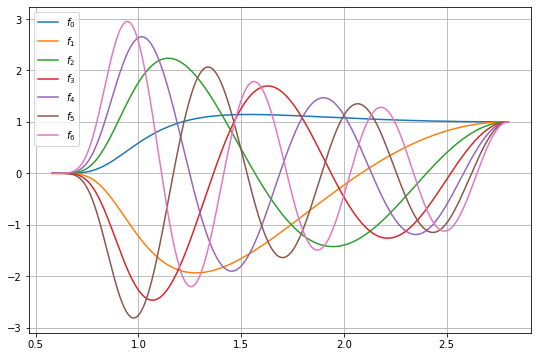

In [4]:
# create function for every fn and derivatives

fn_prime  = np.apply_along_axis(np.gradient, 1, fn, rgrid)
fn_prime[:, -11:] = 0.

fn_second = np.apply_along_axis(np.gradient, 1, fn_prime, rgrid)

f0 = njit(lambda r: np.interp(r, rgrid, fn[0]), fastmath=True)
f0_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[0]), fastmath=True)
f0_second = njit(lambda r: np.interp(r, rgrid, fn_second[0]), fastmath=True)

f1 = njit(lambda r: np.interp(r, rgrid, fn[1]), fastmath=True)
f1_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[1]), fastmath=True)
f1_second = njit(lambda r: np.interp(r, rgrid, fn_second[1]), fastmath=True)

f2 = njit(lambda r: np.interp(r, rgrid, fn[2]), fastmath=True)
f2_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[2]), fastmath=True)
f2_second = njit(lambda r: np.interp(r, rgrid, fn_second[2]), fastmath=True)

f3 = njit(lambda r: np.interp(r, rgrid, fn[3]), fastmath=True)
f3_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[3]), fastmath=True)
f3_second = njit(lambda r: np.interp(r, rgrid, fn_second[3]), fastmath=True)

f4 = njit(lambda r: np.interp(r, rgrid, fn[4]), fastmath=True)
f4_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[4]), fastmath=True)
f4_second = njit(lambda r: np.interp(r, rgrid, fn_second[4]), fastmath=True)

f5 = njit(lambda r: np.interp(r, rgrid, fn[5]), fastmath=True)
f5_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[5]), fastmath=True)
f5_second = njit(lambda r: np.interp(r, rgrid, fn_second[5]), fastmath=True)

f6 = njit(lambda r: np.interp(r, rgrid, fn[6]), fastmath=True)
f6_prime  = njit(lambda r: np.interp(r, rgrid, fn_prime[6]), fastmath=True)
f6_second = njit(lambda r: np.interp(r, rgrid, fn_second[6]), fastmath=True)

for i in range(7):
    plt.plot(rgrid, eval(f'f{i}(rgrid)'), label=f'$f_{i}$')

plt.legend()
plt.grid()

[ 0.90800615  0.10698935 -0.01974887  0.00929631 -0.00470635  0.00318622
 -0.00302281]


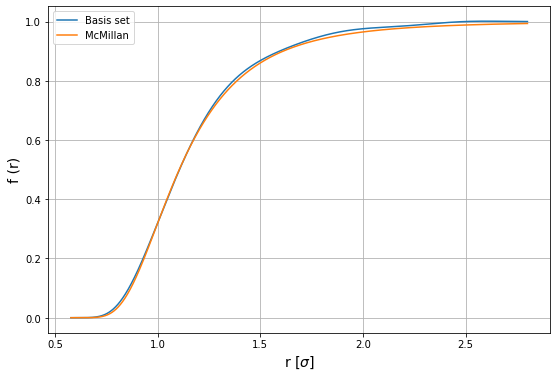

In [5]:
# starting values of cn: fit f on McMillan function
def f_fit(r, c0, c1, c2, c3, c4, c5, c6):
    return c0*f0(r) + c1*f1(r) + c2*f2(r) + c3*f3(r) + c4*f4(r) + c5*f5(r) + c6*f6(r)

McMillan = np.exp(- 0.5 * (1.18**5 / rgrid**5))
cn, pcov = curve_fit(f_fit, rgrid, McMillan)

cn = cn / np.sum(cn)

print(cn)

plt.plot(rgrid, f_fit(rgrid, *cn),  label='Basis set')
plt.plot(rgrid, np.exp(- 0.5 * (1.18**5 / rgrid**5)), label='McMillan')
plt.xlabel('r [$\\sigma$]', fontsize=14)
plt.ylabel('f (r)', fontsize=14)
plt.legend()
plt.grid()

In [6]:
@njit(fastmath=True)
def psi(conf, f, L):
    # pairwise vector distance matrix
    R_ij = conf - np.expand_dims(conf, axis=1)
    R_ij = R_ij - L * np.rint(R_ij / L)

    # pairwise distance matrix
    r_ij = np.sqrt(np.sum(R_ij**2, axis=2))
    
    r_ij = np.where((r_ij > 0) & (r_ij < L/2), r_ij, L/2)
    
    return np.sqrt(np.prod(f(r_ij)))

In [7]:
@njit(fastmath=True) # sample MC configurations on psi(*, f)
def sample(conf, f, L, n_samples):
    # number of particles
    N = conf.shape[0]
    # equilibration steps
    eq_steps = 15000
    
    # delta parameter starting value
    delta = L / 10
    
    # forward steps in Markov chain
    fw_steps = 0

    # EQUILIBRATION: bring system to equilibrium
    P_i = psi(conf, f, L)**2
    for i in range(eq_steps):    
        # sample random particles to move
        to_move = np.random.choice(N, size=N//4, replace=False)
        
        # build proposal for the step
        proposal = np.copy(conf)
        proposal[to_move] += delta * (np.random.rand(N//4, 3) - 0.5)
        proposal = proposal - L * np.floor(proposal / L) # pbc
        
        # probability of proposal configuration
        P_p = psi(proposal, f, L)**2
        # Markov chain step decision
        if (P_p / P_i) > np.random.rand():
            conf = np.copy(proposal)
            P_i = float(P_p)
            fw_steps += 1

        # update delta value every 500 steps based on % of forward steps
        if ((i+1) % 500 == 0):
            if (fw_steps > 0.29 * 500) or (fw_steps < 0.33 * 500):
                delta = delta * (1 + fw_steps/500 - 0.31)
            # reset forward steps counter
            fw_steps = 0
    
    Ecorr = np.zeros(10000)
    for i in range(10000):
        Ecorr[i] = local_energy(conf, f, f_prime, f_second, L)
        
        # sample random particles to move
        to_move = np.random.choice(N, size=N//4, replace=False)

        # build proposal for the step
        proposal = np.copy(conf)
        proposal[to_move] += delta * (np.random.rand(N//4, 3) - 0.5)
        proposal = proposal - L * np.floor(proposal / L) # pbc
        
        # probability of proposal configuration
        P_p = psi(proposal, f, L)**2
        # Markov chain step decision
        if (P_p / P_i) > np.random.rand():
            conf = np.copy(proposal)
            P_i = float(P_p)
    
    # compute autocorrelation coefficient
    c_tau = autocorrelation(Ecorr)
    
    # fit to find tau_bar (correlation length)
    x = np.arange(50)
    y = np.log(c_tau)

    tau_bar = - ((x*x).sum() - x.mean() * x.sum()) 
    tau_bar = tau_bar / ((x*y).sum() - x.sum() * y.mean())
    tau_bar = int(np.ceil(tau_bar / 10) * 10)
    
    samples = np.zeros((n_samples, N, 3))
    samples[0] = np.copy(conf)

    P_i = psi(conf, f, L)**2

    # SAMPLING
    for i in range(n_samples * tau_bar):
        # sample random particles to move
        to_move = np.random.choice(N, size=N//4, replace=False)

        # build proposal for the step
        proposal = np.copy(conf)
        proposal[to_move] += delta * (np.random.rand(N//4, 3) - 0.5)
        proposal = proposal - L * np.floor(proposal / L) # pbc
        
        # probability of proposal configuration
        P_p = psi(proposal, f, L)**2
        if (P_p / P_i) > np.random.rand():
            conf = np.copy(proposal)
            P_i = float(P_p)
        
        if i % tau_bar == 0:
            samples[i // tau_bar] = np.copy(conf)

    return samples

In [8]:
@njit(fastmath=True) # compute autocorrelation coefficient
def autocorrelation(E):
    tau_max = 50
    c_tau = np.zeros(tau_max)
            
    # iterate over tau
    for tau in range(tau_max):
        for i in range(len(E) - tau):
            c_tau[tau] += E[i] * E[i + tau] / (len(E) - tau)

    # compute coefficent for every tau
    c_tau = (c_tau - np.mean(E)**2) / np.var(E)
    
    return c_tau


@njit(fastmath=True)
def local_energy(conf, f, f_prime, f_second, L):
    # pairwise vetor distance matrix
    R_kl = conf - np.expand_dims(conf, axis=1)
    R_kl = R_kl - L * np.rint(R_kl / L)

    # pairwise distance matrix
    r_kl = np.sqrt(np.sum(R_kl**2, axis=2))
    # avoid r_ii and cutoff at L/2
    r_kl = np.where((r_kl < L/2) & (r_kl > 0), r_kl, L/2)

    f_kl = f(r_kl)
    
    u_prime  = - f_prime(r_kl) / f_kl
    u_second = u_prime**2 - f_second(r_kl) / f_kl

    grad = np.sum(u_prime  / r_kl * R_kl.T, axis=1)

    E  = eta / 2 * np.sum(u_second + 2 / r_kl * u_prime) # Laplacian
    E -= eta / 2 * np.sum(grad**2) # square of the gradient

    # cutoff on potential
    r_kl = np.where(r_kl < L/2, r_kl, -1.)
    E += np.sum(V_lj(r_kl)) / 2
    
    return E

In [9]:
@njit(fastmath=True)
def energy(samples, f, f_prime, f_second, L):
    # number of particles
    N = samples.shape[1]
    # number of uncorrelated samples
    n_samples = samples.shape[0]
    
    # psi_j / psi_0
    psi_j0 = np.zeros((7, n_samples))
    # local energy
    E_l = np.zeros(n_samples)
    # E_lj
    E_lj = np.zeros((7, n_samples))
    
    for i in range(n_samples):
        # pairwise vetor distance matrix
        R_kl = samples[i] - np.expand_dims(samples[i], axis=1)
        R_kl = R_kl - L * np.rint(R_kl / L)

        # pairwise distance matrix
        r_kl = np.sqrt(np.sum(R_kl**2, axis=2))
        # avoid r_ii and cutoff at L/2
        r_kl = np.where((r_kl < L/2) & (r_kl > 0), r_kl, L/2)
        
        f_kl = f(r_kl)

        u0 = - f0(r_kl) / f_kl
        u1 = - f1(r_kl) / f_kl
        u2 = - f2(r_kl) / f_kl
        u3 = - f3(r_kl) / f_kl
        u4 = - f4(r_kl) / f_kl
        u5 = - f5(r_kl) / f_kl
        u6 = - f6(r_kl) / f_kl
        
        u_prime  = - f_prime(r_kl) / f_kl
        
        u0_prime = - f0_prime(r_kl) / f_kl + u_prime * u0
        u1_prime = - f1_prime(r_kl) / f_kl + u_prime * u1
        u2_prime = - f2_prime(r_kl) / f_kl + u_prime * u2
        u3_prime = - f3_prime(r_kl) / f_kl + u_prime * u3
        u4_prime = - f4_prime(r_kl) / f_kl + u_prime * u4
        u5_prime = - f5_prime(r_kl) / f_kl + u_prime * u5
        u6_prime = - f6_prime(r_kl) / f_kl + u_prime * u6
        
        u_second = u_prime**2 - f_second(r_kl) / f_kl
        
        u0_second  = - f0_second(r_kl) / f_kl + u0 * (u_second - u_prime**2)
        u0_second += 2 * u_prime * u0_prime
        
        u1_second  = - f1_second(r_kl) / f_kl + u1 * (u_second - u_prime**2)
        u1_second += 2 * u_prime * u1_prime
        
        u2_second  = - f2_second(r_kl) / f_kl + u2 * (u_second - u_prime**2)
        u2_second += 2 * u_prime * u2_prime
        
        u3_second  = - f3_second(r_kl) / f_kl + u3 * (u_second - u_prime**2)
        u3_second += 2 * u_prime * u3_prime
        
        u4_second  = - f4_second(r_kl) / f_kl + u4 * (u_second - u_prime**2)
        u4_second += 2 * u_prime * u4_prime
        
        u5_second  = - f5_second(r_kl) / f_kl + u5 * (u_second - u_prime**2)
        u5_second += 2 * u_prime * u5_prime
        
        u6_second  = - f6_second(r_kl) / f_kl + u6 * (u_second - u_prime**2)
        u6_second += 2 * u_prime * u6_prime
        
        grad  = np.sum(u_prime  / r_kl * R_kl.T, axis=1)
        grad0 = np.sum(u0_prime / r_kl * R_kl.T, axis=1)
        grad1 = np.sum(u1_prime / r_kl * R_kl.T, axis=1)
        grad2 = np.sum(u2_prime / r_kl * R_kl.T, axis=1)
        grad3 = np.sum(u3_prime / r_kl * R_kl.T, axis=1)
        grad4 = np.sum(u4_prime / r_kl * R_kl.T, axis=1)
        grad5 = np.sum(u5_prime / r_kl * R_kl.T, axis=1)
        grad6 = np.sum(u6_prime / r_kl * R_kl.T, axis=1)
        
        psi_j0[0, i] = np.sum(- u0) / 2
        psi_j0[1, i] = np.sum(- u1) / 2
        psi_j0[2, i] = np.sum(- u2) / 2
        psi_j0[3, i] = np.sum(- u3) / 2
        psi_j0[4, i] = np.sum(- u4) / 2
        psi_j0[5, i] = np.sum(- u5) / 2
        psi_j0[6, i] = np.sum(- u6) / 2
        
        psi_j0[:, i] -= len(np.where(r_kl == L/2)[0]) / 2
        
        E_lj[0, i] = np.sum(u0_second + 2/r_kl * u0_prime) # Laplacian
        E_lj[0, i] -= 2 * np.sum(grad * grad0)
        
        E_lj[1, i] = np.sum(u1_second + 2/r_kl * u1_prime) # Laplacian
        E_lj[1, i] -= 2 * np.sum(grad * grad1)
        
        E_lj[2, i] = np.sum(u2_second + 2/r_kl * u2_prime) # Laplacian
        E_lj[2, i] -= 2 * np.sum(grad * grad2)
        
        E_lj[3, i] = np.sum(u3_second + 2/r_kl * u3_prime) # Laplacian
        E_lj[3, i] -= 2 * np.sum(grad * grad3)
        
        E_lj[4, i] = np.sum(u4_second + 2/r_kl * u4_prime) # Laplacian
        E_lj[4, i] -= 2 * np.sum(grad * grad4)
        
        E_lj[5, i] = np.sum(u5_second + 2/r_kl * u5_prime) # Laplacian
        E_lj[5, i] -= 2 * np.sum(grad * grad5)
        
        E_lj[6, i] = np.sum(u6_second + 2/r_kl * u6_prime) # Laplacian
        E_lj[6, i] -= 2 * np.sum(grad * grad6)
        
        E_l[i]  = eta / 2 * np.sum(u_second + 2/r_kl * u_prime) # Laplacian
        E_l[i] -= eta / 2 * np.sum(grad**2) # square of the gradient
        
        # cutoff on potential
        r_kl = np.where(r_kl < L/2, r_kl, -1.)
        E_l[i] += np.sum(V_lj(r_kl)) / 2
    
    E_lj = eta / 2 * E_lj
    return E_l, E_lj, psi_j0

In [10]:
def build_HS(E_l, E_lj, psi_j0):
    S = np.zeros((6, 6))
    S[0, 0] = 1.

    for i in range(5):
        for j in range(i, 5):
            S[i+1, j+1]  = np.mean(psi_j0[i] * psi_j0[j]) 
            S[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(psi_j0[j])
            S[j+1, i+1]  = float(S[i+1, j+1])

    H = np.zeros((6, 6))
    H[0, 0] = np.mean(E_l)

    for i in range(5):
        H[i+1, 0] = np.mean(E_l * psi_j0[i]) - H[0, 0] * np.mean(psi_j0[i]) + np.mean(E_lj[i])
        H[0, i+1] = np.mean(E_l * psi_j0[i]) - H[0, 0] * np.mean(psi_j0[i])

    for i in range(5):
        for j in range(5):
            H[i+1, j+1]  = np.mean(psi_j0[i] * psi_j0[j] * E_l)
            H[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(psi_j0[j] * E_l)
            H[i+1, j+1] -= np.mean(psi_j0[i] * E_l) * np.mean(psi_j0[j])
            H[i+1, j+1] += np.mean(psi_j0[i]) * np.mean(psi_j0[j]) * H[0, 0]
            H[i+1, j+1] += np.mean(psi_j0[i] * E_lj[j]) 
            H[i+1, j+1] -= np.mean(psi_j0[i]) * np.mean(E_lj[j])
            
    return H, S


# long-range correction
def LRC(N, L):
    rho = N / L**3
    rc = L / 2
    return 8/3 * N * np.pi * rho * (1 / (3*rc**9) - 1 / rc**3)

In [11]:
import datetime as dt

def time():
    now = dt.datetime.now()
    return f'{now.time().hour:02d}:{now.time().minute:02d} {now.date()}'

In [ ]:
%%time

var_steps = 20

El = np.zeros(var_steps)
sigmaEl = np.zeros(var_steps)

e  = np.zeros(var_steps)
p  = np.zeros((var_steps, 5))

n_samples = 100000

p[0] = np.copy(cn)

time = f'{dt.datetime.now().time().hour:02d}:{dt.datetime.now().time().minute:02d}'
print(f'Start: {time} {dt.datetime.now().date()}')

for i in range(var_steps):
    f_num        = np.sum(p[i] * fn.T, axis=1)
    f_prime_num  = np.sum(p[i] * fn_prime.T, axis=1)
    f_second_num = np.sum(p[i] * fn_second.T, axis=1)

    f        = njit(lambda r: np.interp(r, rgrid, f_num), fastmath=True)
    f_prime  = njit(lambda r: np.interp(r, rgrid, f_prime_num),  fastmath=True)
    f_second = njit(lambda r: np.interp(r, rgrid, f_second_num), fastmath=True)
    
    samples = sample(conf, f, L, n_samples)
    E_l, E_lj, psi_j0 = energy(samples, f, f_prime, f_second, L)
    
    H, S = build_HS(E_l + LRC(N, L), E_lj, psi_j0+1)
    E, P = eig(H, S)
    
    E = np.real(E)
    P = np.real(P)
    
    e[i] = np.min(E) / N * epsilon

    delta_p = P[1:, np.argmin(E)] / P[0, np.argmin(E)]
    if i < (var_steps-1):
        p[i+1] = p[i] + delta_p
        p[i+1] = p[i+1] / np.sum(p[i+1])
    
    El[i]      = (np.mean(E_l) + LRC(N, L)) / N * epsilon
    sigmaEl[i] = np.std(E_l) / np.sqrt(n_samples) / N * epsilon
    
    repE = f'$E_l = {El[i]:.5f} \pm {sigmaEl[i]:.5f} K$, $\epsilon$ = {e[i]:.5f}'
    display(Latex(f'Step {i+1} at {time()}: ' + repE))

In [ ]:
plt.errorbar(np.arange(var_steps)+1, El, fmt='.', markersize=10, yerr=sigmaEl, label='$E_l$')
plt.scatter(np.arange(var_steps)+1, e, s=15, color='tab:orange', label='$\\epsilon$')

plt.xlabel('Step', fontsize=14)
plt.ylabel('E [K]', fontsize=14)

plt.legend()
plt.grid()

## To check:

* precision of the sampling
* $\frac{\psi_j}{\psi_0} + 1$ ?

In [12]:
f_num        = np.sum(cn * fn.T, axis=1)
f_prime_num  = np.sum(cn * fn_prime.T, axis=1)
f_second_num = np.sum(cn * fn_second.T, axis=1)

f        = njit(lambda r: np.interp(r, rgrid, f_num), fastmath=True)
f_prime  = njit(lambda r: np.interp(r, rgrid, f_prime_num),  fastmath=True)
f_second = njit(lambda r: np.interp(r, rgrid, f_second_num), fastmath=True)

In [ ]:
%%time

from multiprocessing import Pool

n_samples = int(2e5)

args = [(conf, f, L, n_samples)]

with Pool(5) as p:
    samples = p.starmap(sample, 5*args)

In [ ]:
%%time
args = [(samples[i], f, f_prime, f_second, L) for i in range(5)]

with Pool(5) as p:
    eee = p.starmap(energy, args)

In [ ]:
E = np.zeros(int(1e6))

for i in range(5):
    E[i*int(2e5):(i+1)*int(2e5)] = eee[i][0]

In [ ]:
np.mean(E) / N * epsilon, np.std(E) / N * epsilon / 1000

In [ ]:
%%time
n_samples = int(2.5e5)

args = [(conf, f, L, n_samples)]

with Pool(4) as p:
    samples = p.starmap(sample, 4*args)

In [ ]:
%%time
args = [(samples[i], f, f_prime, f_second, L) for i in range(4)]

with Pool(4) as p:
    eee = p.starmap(energy, args)

In [ ]:
E = np.zeros(int(1e6))

for i in range(4):
    E[i*n_samples:(i+1)*n_samples] = eee[i][0]

In [ ]:
np.mean(E) / N * epsilon, np.std(E) / N * epsilon / 1000